In [1]:
# import libary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

## **Load dataset**

In [2]:
dataset_path = "./teaSicknessDataset"
dataset_dir = pathlib.Path(dataset_path)

In [3]:
# list of sub directory(class)
class_names = []
for x in os.walk(dataset_path):
    sub_dir = x[0]

    sub_dir_list = str(sub_dir).split('\\')
    if len(sub_dir_list) > 0:
        x_class = (sub_dir_list[-1])
        class_names.append(x_class)
class_names.pop(0)
print(class_names)

['algal leaf', 'Anthracnose', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [4]:
# print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)

Images in class algal leaf: 452
Images in class Anthracnose: 400
Images in class bird eye spot: 400
Images in class brown blight: 452
Images in class gray light: 400
Images in class healthy: 292
Images in class red leaf spot: 572
Images in class white spot: 568


In [5]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [6]:
# Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 3536 files belonging to 8 classes.
Using 2829 files for training.


In [7]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,                                                            
                                                     validation_split=val_split,                                                            
                                                     subset="validation",                                                     
                                                     seed=123,                                                     
                                                     image_size=(img_height, img_width),                                                     
                                                     batch_size=val_batch                                                           
                                                    )

Found 3536 files belonging to 8 classes.
Using 707 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


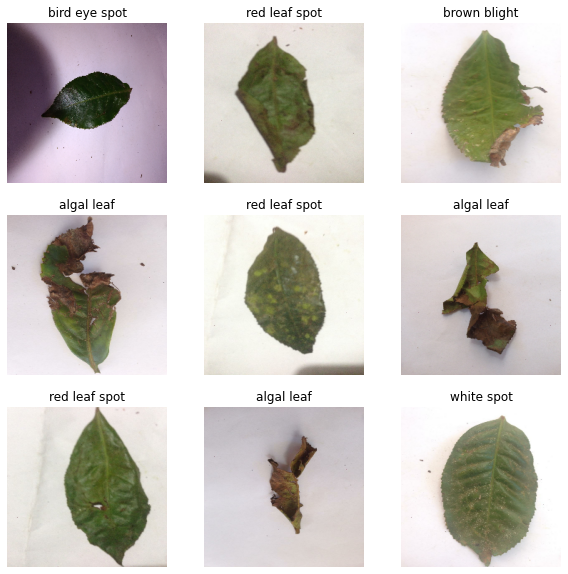

In [9]:
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


## **Data Preprocessing**

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## **Build Model**

In [11]:
## Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [12]:
# Model architecture
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

In [13]:
# compile model
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

## **Train Model**

In [15]:
epochs=320
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=0
)

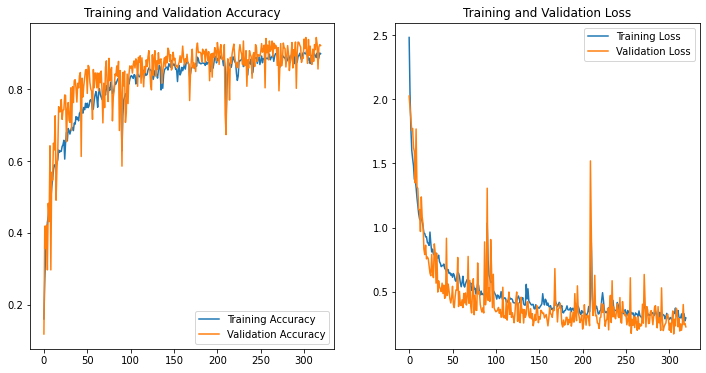

In [16]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Evaluate Model**

Predictions:
 [7 0 4 5 6 4 6 1 1 6 7 4 3 4 4 6 7 7 0 0 7 1 5 4 0 6 7 3 7 6 6 6 6 1 2 4 4
 2 1 0 4 5 4 6 1 7 3 7 3 7 7 5 7 1 4 3 4 6 3 7 6 1 3 4 0 6 4 1 6 6 4 6 6 3
 5 6 4 3 4 5 6 4 1 3 3 1 2 0 7 3 1 6 7 1 3 3 6 7 0 1 7 0 1 2 6 4 7 6 6 6 3
 3 3 6 6 7 5 1 2 0 0 7 1 2 1 7 6 7]
Labels:
 [7 2 4 5 6 4 6 1 1 6 7 4 3 4 0 6 7 7 0 0 7 1 5 2 0 6 7 3 7 6 6 6 6 1 0 0 4
 2 1 0 4 5 4 6 1 3 3 7 3 7 7 5 7 1 4 3 4 6 3 7 6 1 3 4 2 6 4 1 6 6 4 6 6 3
 5 6 4 3 4 5 6 4 1 3 3 1 2 0 7 3 1 6 7 1 3 3 6 7 0 1 7 0 1 2 6 0 7 6 6 6 3
 3 3 6 6 7 5 1 2 0 0 7 1 2 1 7 6 7]

              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       1.00      1.00      1.00        18
           2       0.83      0.62      0.71         8
           3       1.00      0.94      0.97        18
           4       0.79      1.00      0.88        15
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00        28
           7       0.

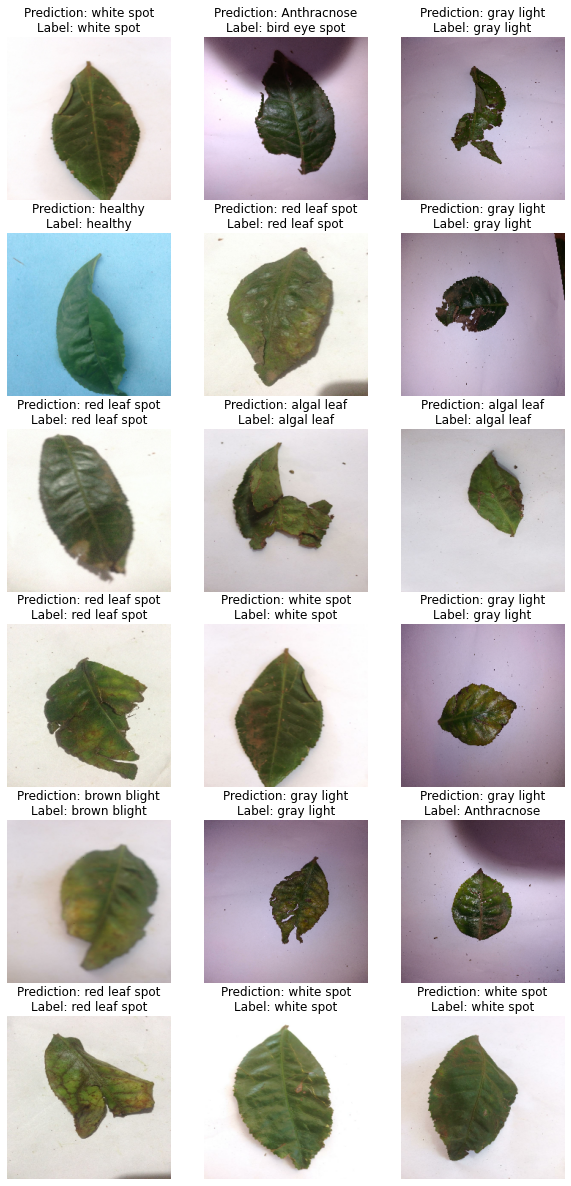

In [17]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

## **Save Model History**

In [20]:
history_df = pd.DataFrame(history.history)
history_df.to_csv("history.csv")
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
315,0.284818,0.900318,0.248222,0.925035
316,0.327608,0.880170,0.399291,0.855728
317,0.326491,0.886886,0.242031,0.916549
318,0.271368,0.900318,0.251306,0.923621
319,0.293938,0.898197,0.224627,0.920792
